In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

In [156]:
%run Model.ipynb

In [158]:
problems = load_problems("/Users/simonhusebo/Dokumenter/MASTERS CODE/data")
problem_types = ['16_4_4', '30_5_7','42_7_10','72_9_18','121_11_35','300_20_70']

<Axes: title={'center': 'Instance: 23'}>

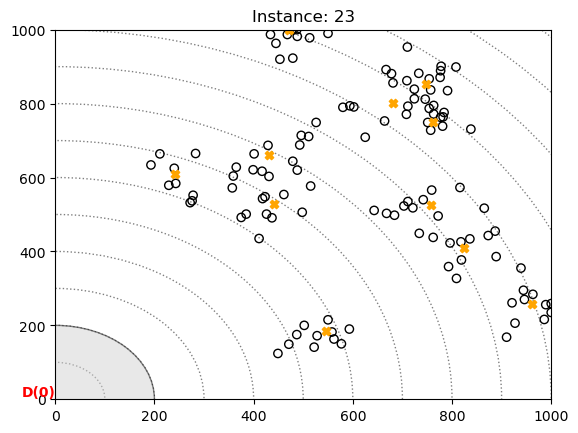

In [159]:
instance = 23
problem = problems[instance-1]
n_trips = problem['N_trips']
initial = initial_solution(problem,n_trips)
operators = [random_remove_greedy_insert,largest_trip_remove_greedy_insert,similarity_removal_greedy_insert,worst_removal_greedy_insert,smallest_trip_removal_greedy_insert,random_remove_kregret_insert,largest_trip_remove_kregret_insert,similarity_removal_kregret_insert,worst_removal_kregret_insert,smallest_trip_removal_kregret_insert,clustering_removal_kncs_greedy_insert,clustering_removal_krd_greedy_insert,clustering_removal_kncs_kregret_insert,clustering_removal_krd_kregret_insert]
weights = [1/4,1/4,1/4,1/16,1/16]
show_the_map(problem, title = instance,save_ = False, save_name = "/Users/simonhusebo/Dokumenter/MASTERS CODE/figures/instance"+str(instance)+".png")


In [160]:
print(problem['Vessels'])

{1: [1, 1500.0, 3.0, 20.0, 12.0, 20000.0], 2: [2, 2000.0, 6.0, 22.0, 17.0, 22500.0], 3: [3, 2750.0, 11.0, 25.0, 25.0, 27500.0]}


In [161]:
#sol,cost,n_feasible,cost_movement = simple_sim_annealing(inital,problem,operators,probabilities)

In [162]:
best_solution,processed_best,best_cost,best_costs,costs,all_weights,all_scores,all_used,final_improvement,unique,accept_list, deltas = ALNS(initial,problem,operators,5000)

Starting ALNS
Iteration 1k
Escape at 1179
Iteration 2k
Escape at 2180
Iteration 3k
Escape at 3181
Iteration 4k
Escape at 4182
Best cost: 1379262.6400000001


In [163]:
processed_best

([(121, 0),
  (121, 1),
  (59, 0),
  (65, 0),
  (18, 1),
  (66, 0),
  (16, 0),
  (16, 1),
  (48, 1),
  (27, 1),
  (0, 0),
  (118, 0),
  (105, 0),
  (95, 0),
  (15, 0),
  (122, 0),
  (124, 1),
  (30, 1),
  (2, 0),
  (66, 1),
  (84, 1),
  (0, 0),
  (52, 1),
  (24, 0),
  (123, 0),
  (17, 0),
  (100, 0),
  (9, 0),
  (129, 1),
  (69, 1),
  (34, 1),
  (0, 0),
  (35, 0),
  (41, 0),
  (41, 1),
  (93, 1),
  (98, 0),
  (98, 1),
  (95, 1),
  (97, 0),
  (97, 1),
  (76, 0),
  (71, 0),
  (77, 0),
  (17, 1),
  (120, 1),
  (2, 0),
  (132, 0),
  (65, 1),
  (0, 0),
  (68, 0),
  (67, 0),
  (101, 0),
  (107, 0),
  (105, 1),
  (47, 1),
  (75, 1),
  (104, 1),
  (9, 0),
  (0, 0),
  (38, 0),
  (35, 1),
  (110, 0),
  (110, 1),
  (108, 0),
  (56, 1),
  (21, 1),
  (55, 0),
  (55, 1),
  (0, 0),
  (113, 0),
  (113, 1),
  (48, 0),
  (109, 0),
  (68, 1),
  (89, 1),
  (99, 0),
  (64, 0),
  (64, 1),
  (21, 0),
  (59, 1),
  (4, 0),
  (0, 0),
  (0, 0),
  (44, 0),
  (40, 0),
  (40, 1),
  (96, 0),
  (94, 0),
  (58, 1),
  

In [165]:
feasibility_check(processed_best,problem)

Node (47, 0) is visited for pickup before delivery


(False,
 'Passenger check: True. All jobs handled: True. All trips feasible: False. Post processing feasible: [[], [(2, 1509.7700000000002)], [(9, 1717.8900000000003)], [(2, 1547.4299999999998)], [(9, 471.38)], [], [(4, 788.3899999999995)], [], [(1, 441.60000000000025)], [], [(10, 316.52)], [], [(1, 981.84)], [], [(1, 1141.69)], [], [], [(3, 308.8200000000004)], [(5, 489.55999999999983)], [], [(3, 456.18999999999994)], [], [], [(3, 423.0500000000009)], [(7, 427.80000000000007)], [], [], [], [], [], [], [], [], [], []]')

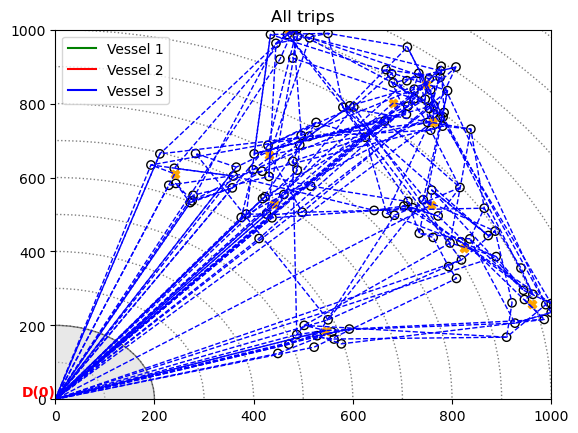

In [166]:
# Create the base map
ax = show_the_map(problem)

# Plot all trips on the map
ax = plot_all_trips(ax, processed_best, problem)

# Display the combined plot
plt.show()

[0, 84, 130, 50, 22, 60, 53, 53, 29, 26, 33, 44, 3, 0]


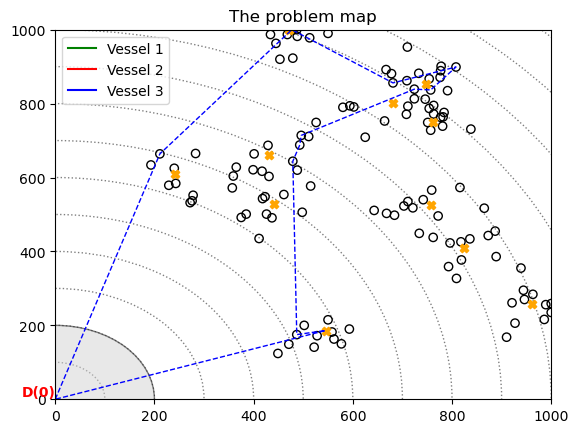

In [167]:
bx = show_the_map(problem)

bx = plot_some_trips(bx, processed_best, problem,1)

plt.show()

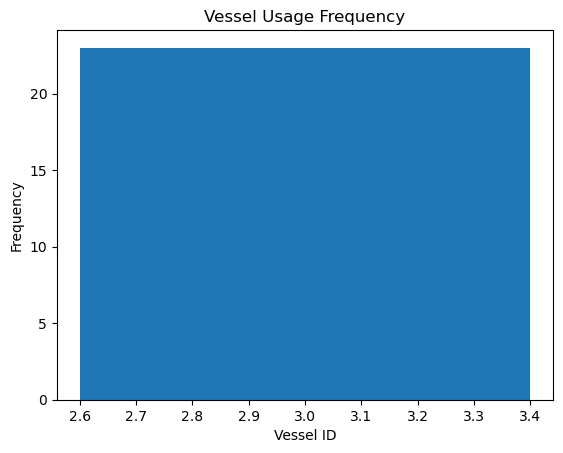

In [168]:
show_vessel_distribution(processed_best)

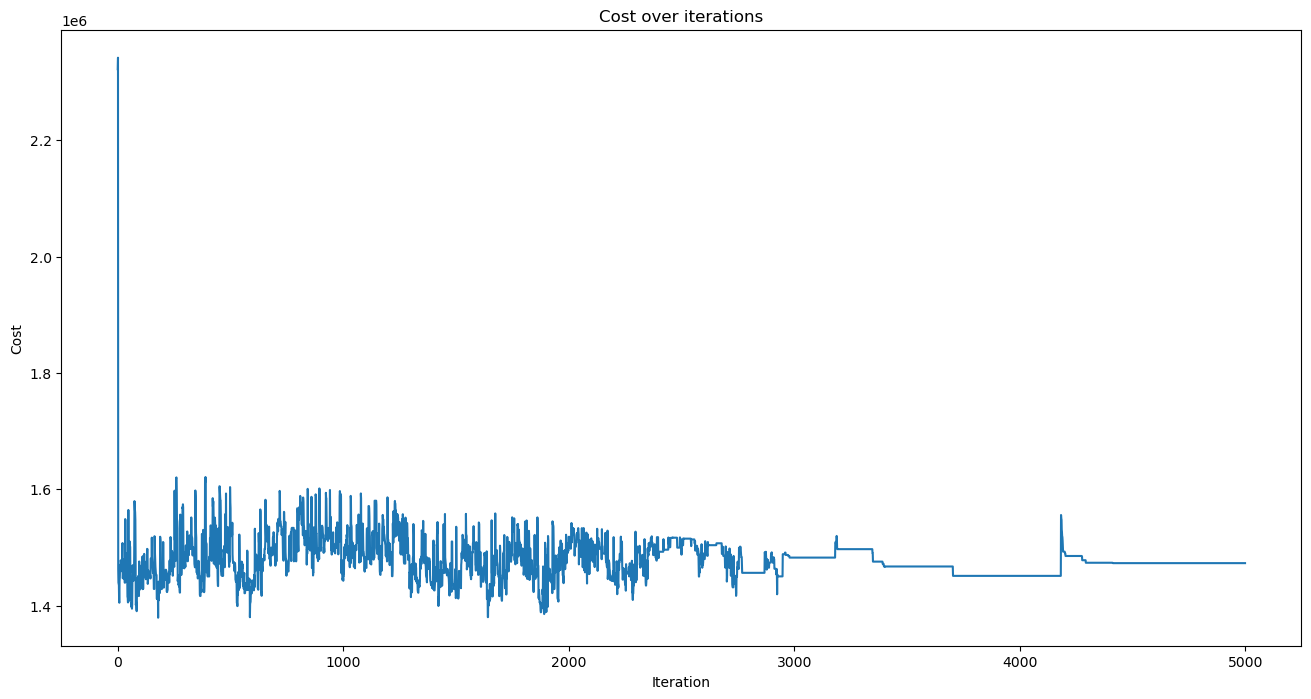

<Axes: title={'center': 'Cost over iterations'}, xlabel='Iteration', ylabel='Cost'>

In [169]:
plot_costs(costs)

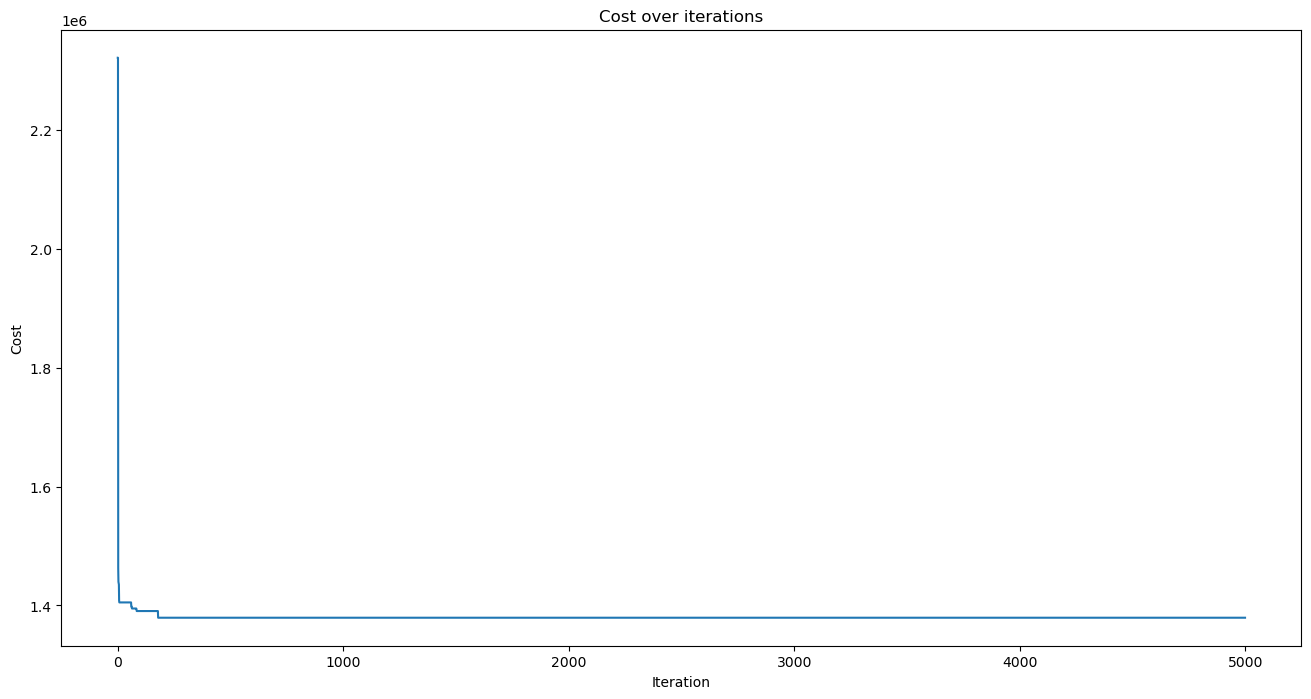

<Axes: title={'center': 'Cost over iterations'}, xlabel='Iteration', ylabel='Cost'>

In [170]:
plot_costs(best_costs)

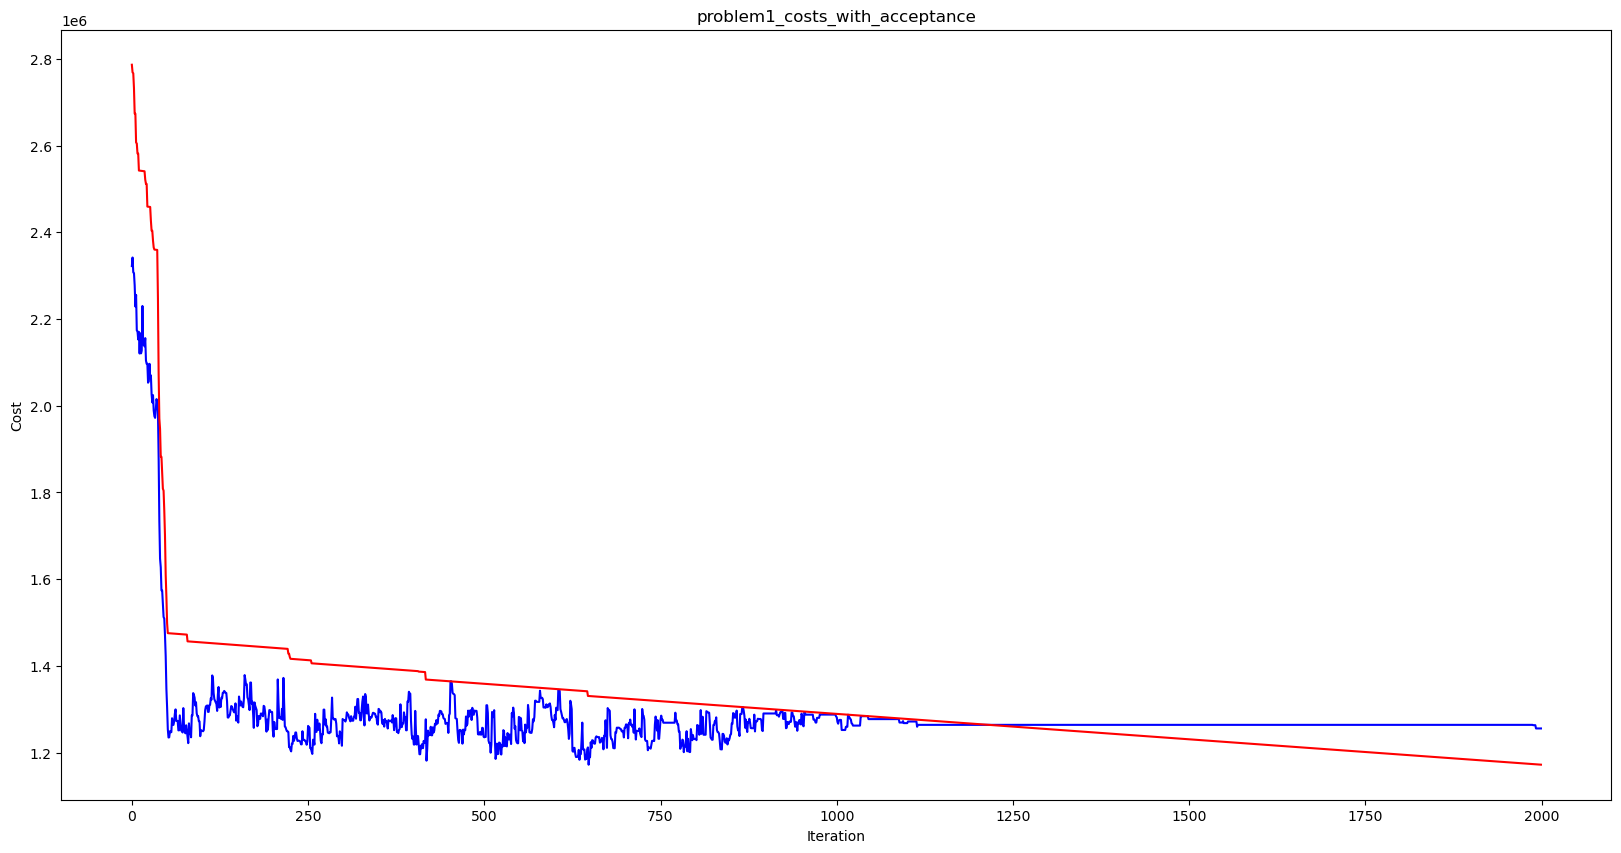

<Axes: title={'center': 'problem1_costs_with_acceptance'}, xlabel='Iteration', ylabel='Cost'>

In [99]:
multiple_plots(costs,accept_list,title='problem1_costs_with_acceptance')

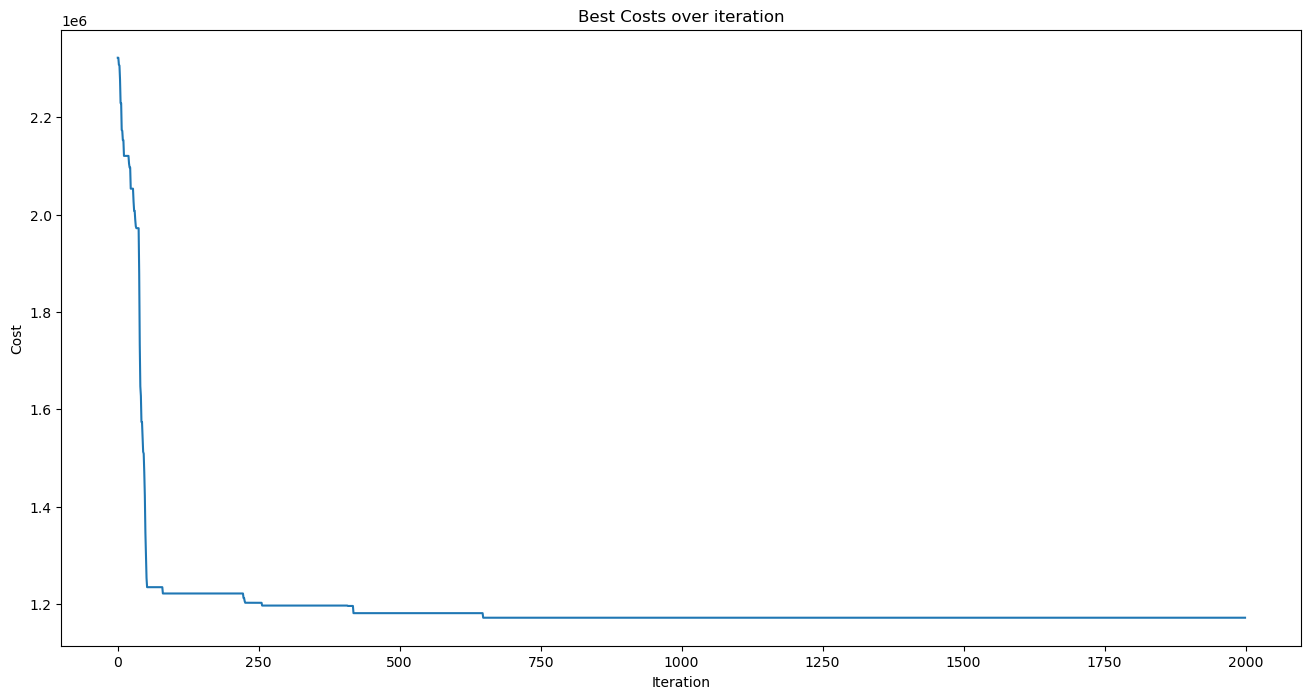

<Axes: title={'center': 'Best Costs over iteration'}, xlabel='Iteration', ylabel='Cost'>

In [100]:
plot_costs(best_costs,title='Best Costs over iteration')

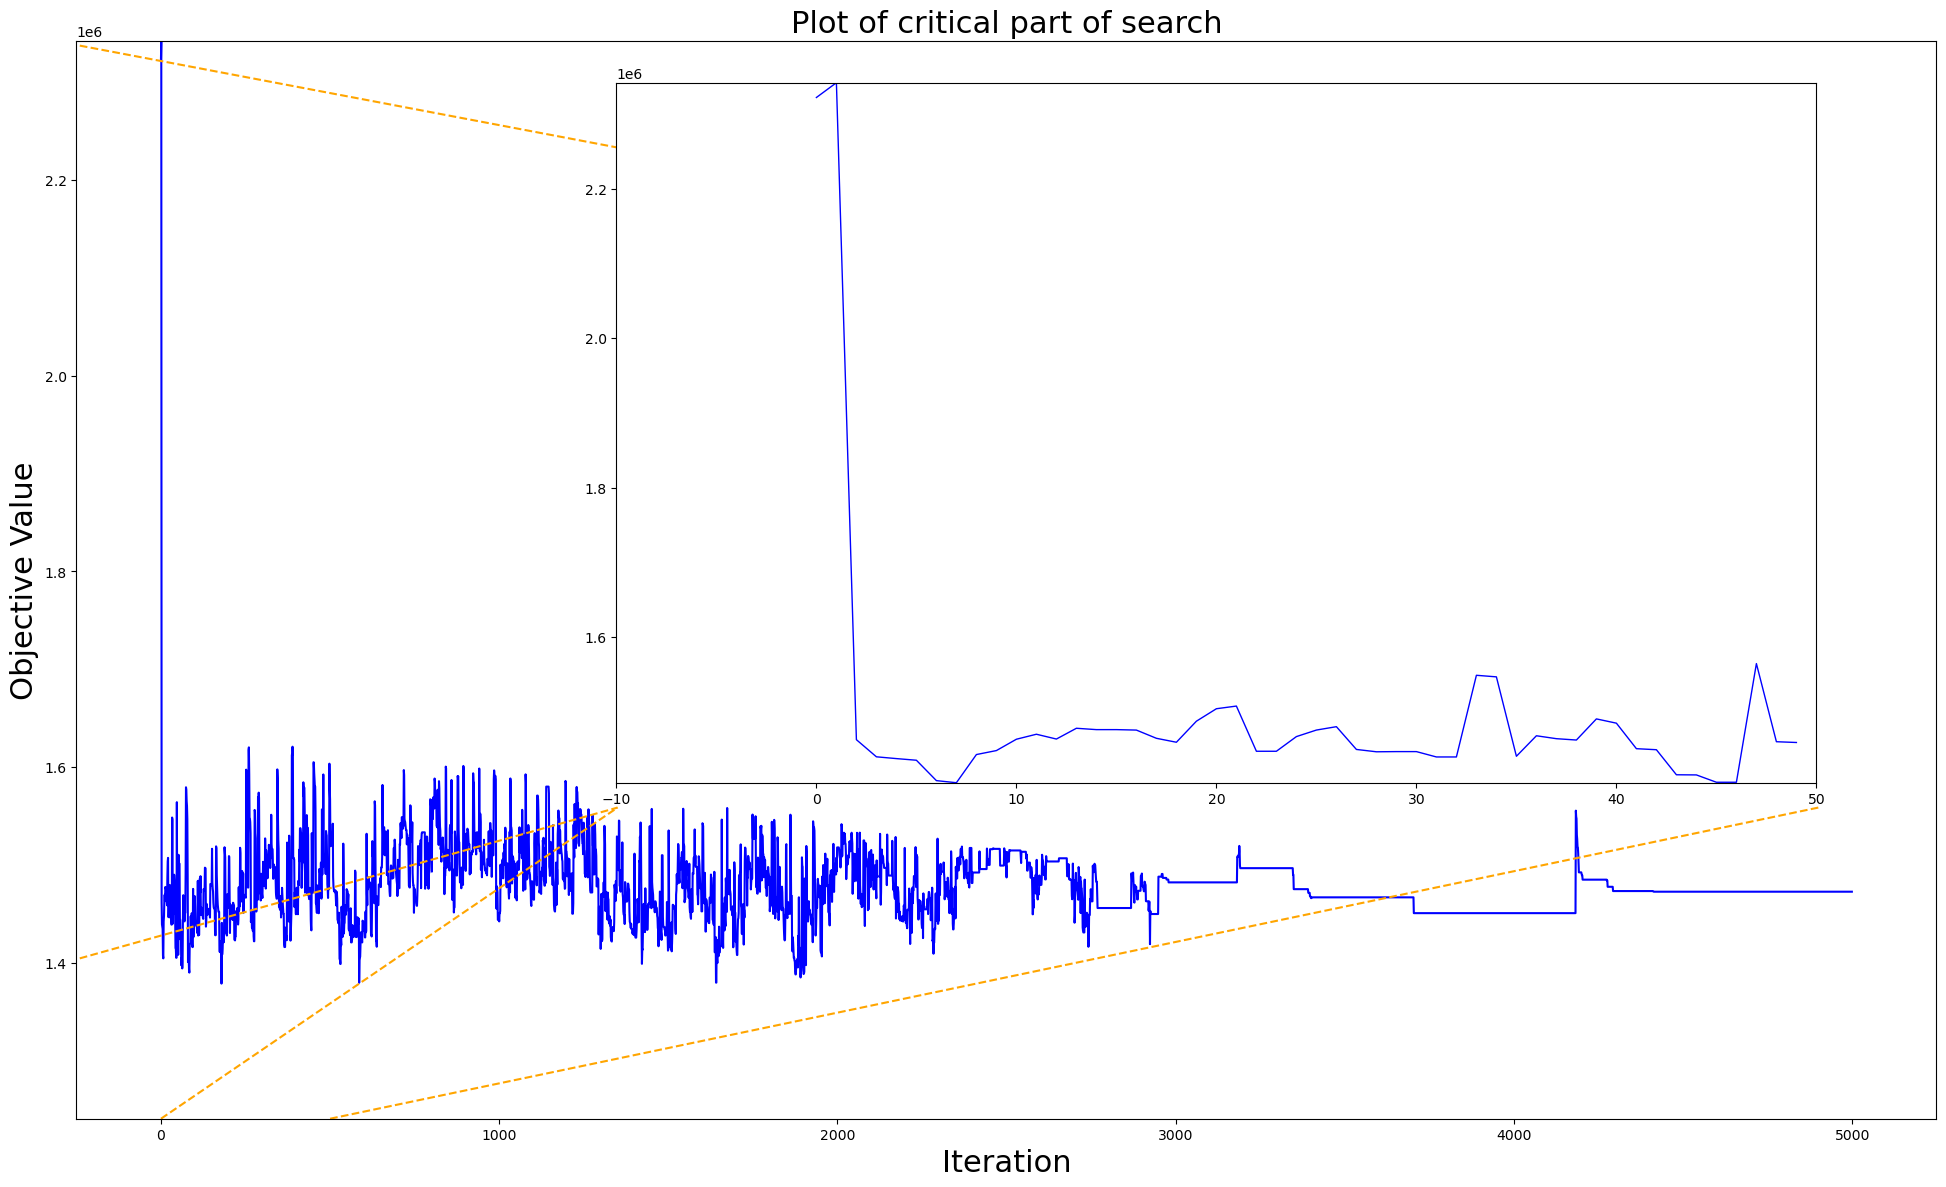

In [171]:
zoomed_plot(costs,0,50)

['random_remove_greedy_insert', 'largest_trip_remove_greedy_insert', 'similarity_removal_greedy_insert', 'worst_removal_greedy_insert', 'smallest_trip_removal_greedy_insert', 'random_remove_kregret_insert', 'largest_trip_remove_kregret_insert', 'similarity_removal_kregret_insert', 'worst_removal_kregret_insert', 'smallest_trip_removal_kregret_insert', 'clustering_removal_kncs_greedy_insert', 'clustering_removal_krd_greedy_insert', 'clustering_removal_kncs_kregret_insert', 'clustering_removal_krd_kregret_insert']


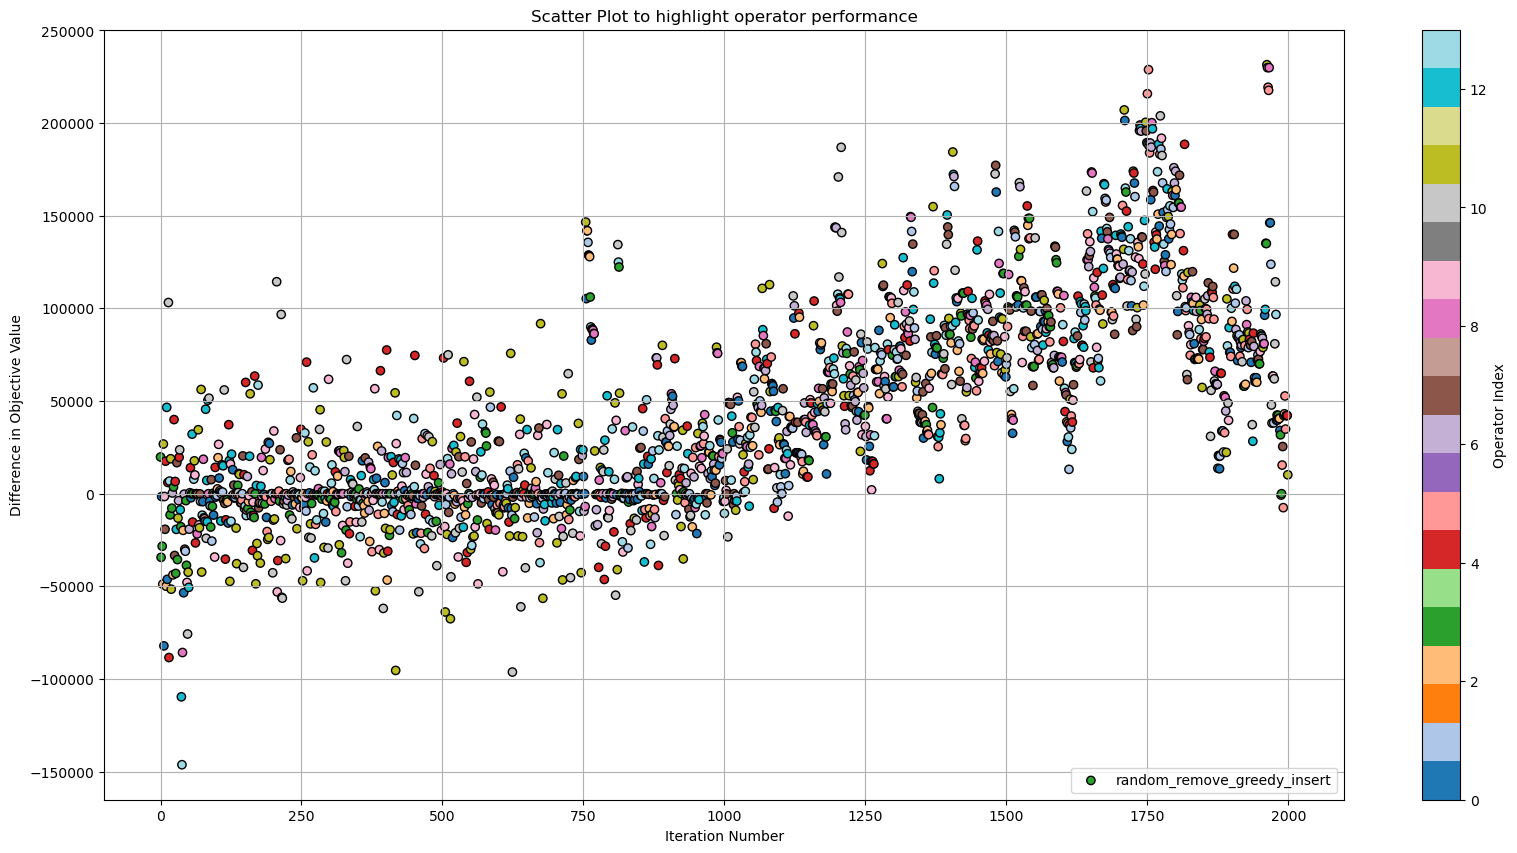

In [103]:
operators_scatter(deltas,operators)

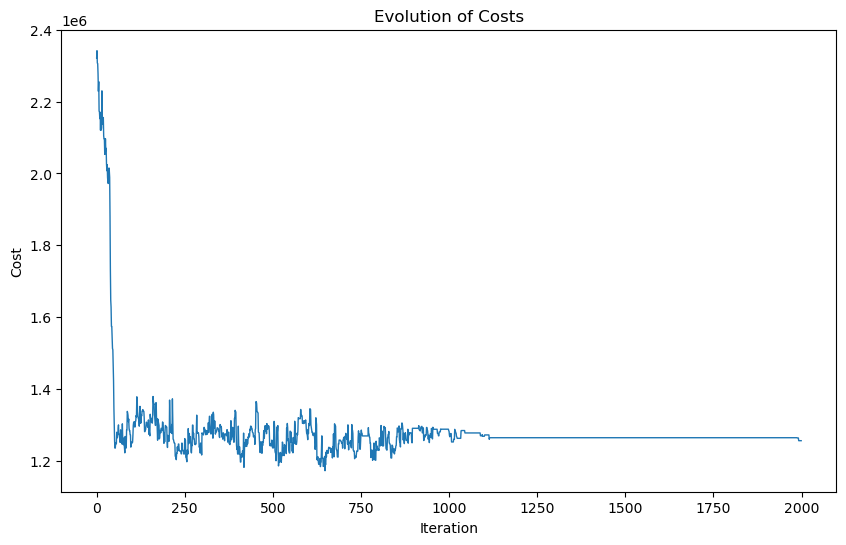

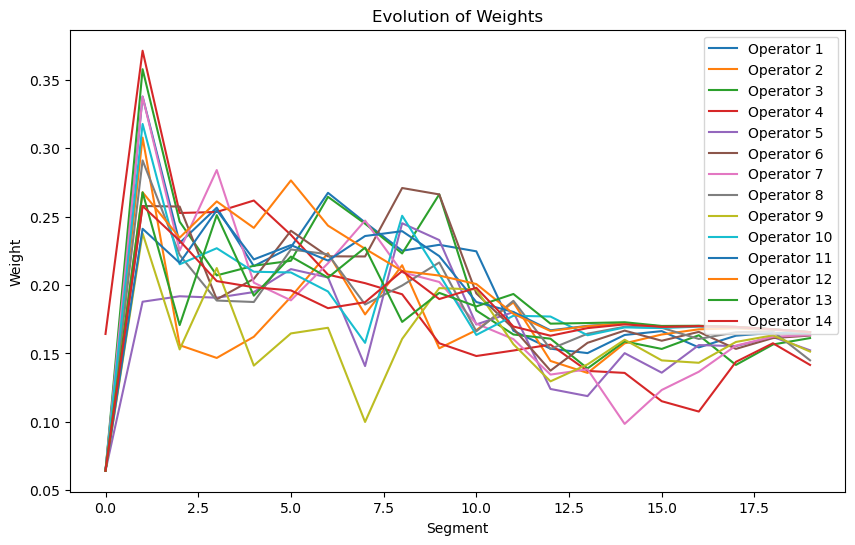

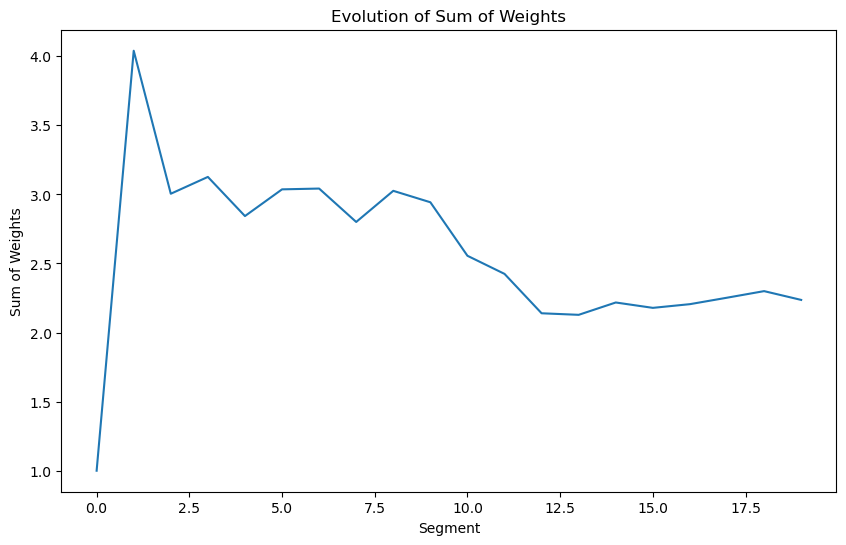

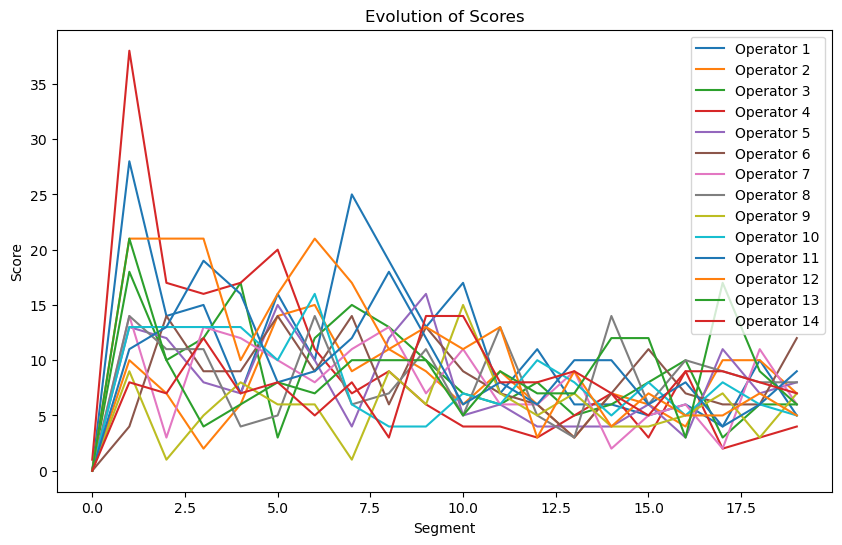

In [104]:
plot_output_lists(costs,all_weights,all_scores)

In [8]:
def multiple_ALNS_runs(problem,operators,n_runs):
    best_solution = 0
    best_cost = float('inf')
    best_run = []
    best_run_best_costs = []
    cost_lists = []
    best_costs_lists = []
    final_improve = []
    avg_cost = []
    t0 = time.time()
    for i in range(n_runs):
        print(f'Starting run {i+1}')
        initial = initial_solution(problem,problem['N_trips'])
        _,processed_best,cost,new_best,costs,_,_,_,final_improvement,_,_, _ = ALNS(initial,problem,operators,5000)
        cost_lists.append(costs)
        best_costs_lists.append(new_best)
        final_improve.append(final_improvement)
        avg_cost.append(cost)
        if cost<best_cost:
            best_solution = processed_best
            best_cost = cost
            best_run = costs
            best_run_best_costs = new_best
            
        
    t1 = time.time()-t0
    print(f'Finished {n_runs} runs in {t1:.2f} seconds')
    avg_cost = sum(avg_cost)/n_runs
    final_improve = sum(final_improve)/n_runs
    cost_lists = [sum(values) / len(values) for values in zip(*cost_lists)]
    best_costs_lists = [sum(values) / len(values) for values in zip(*best_costs_lists)]
    
    time_per_run = t1/n_runs
    
    
    return best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run

In [9]:
def RunAll(problems,operators,n_runs):
    results = {}
    for i in range(len(problems)):
        problem = problems[i]
        print(f'Starting problem {i+1}')
        best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run = multiple_ALNS_runs(problem,operators,n_runs)
        results[i+1]=(best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run)
    return results

In [ ]:
results = RunAll(problems,operators,10)
keys = results.keys()

In [4]:
#with open('5k_n10_all30.pkl', 'wb') as file:
#    pickle.dump(results, file)

with open('/Users/simonhusebo/Dokumenter/MASTERS CODE/results/5k_n10_all30.pkl', 'rb') as file:
    results = pickle.load(file)
keys = results.keys()

In [5]:
instance = 30
problem = problems[instance-1]
processed_best = results[instance][0]
cost = results[instance][3]
best_cost = results[instance][4]
avg_best = results[instance][5]
print(avg_best)


[3246000.0, 3058886.7149999994, 2920538.6595, 2906556.2705000006, 2591794.9795, 2492165.151, 2480349.592, 2463481.743, 2449806.0204999996, 2435946.009, 2417035.914, 2400229.528, 2382135.766, 2359048.154, 2350837.1119999997, 2333379.8099999996, 2321390.6515, 2313089.5225, 2298703.4325, 2285247.3935, 2189553.4345, 2186232.482, 2166959.0345, 2145323.336, 2140070.9469999997, 2137464.431, 2130896.8199999994, 2119704.6829999997, 2107888.0305, 2105244.4390000002, 2093526.2595000002, 2081386.934, 2033792.991, 1929457.424, 1914089.836, 1899722.8195, 1886947.5484999996, 1874890.2585, 1847834.0059999998, 1828195.7349999999, 1817361.0250000004, 1798064.3560000001, 1694571.572, 1689069.5745, 1687742.2314999998, 1687089.9164999998, 1685439.9485000004, 1682306.7215, 1676586.83, 1672194.7610000004, 1669321.7715000003, 1668661.7345000003, 1664092.4280000005, 1658175.0645000003, 1658161.4040000003, 1657231.2655000002, 1656512.3235000002, 1655402.9535, 1654541.698, 1654497.8735000002, 1652154.8790000004,

In [ ]:
a = multiple_plots(cost,avg_best,title=f'Instance {instance}: Best run (blue) Average run (red)')


In [ ]:
zoomed_plot_(cost,0,500,data2=avg_best,save=True,save_name=f'/Users/simonhusebo/Dokumenter/MASTERS CODE/figures/instance{instance}_zoomed.png')

In [65]:
avg_costs = []
plots = []
imps = []
best_costs = []
times = []

keys = list(keys)
for i in range(0,len(keys),5):
    ks = keys[i:i+5]
    costs = sum([results[k][1] for k in ks])/5
    runs = [results[k][5] for k in ks]
    a = [sum(values) / len(values) for values in zip(*runs)]
    imp_iterations = sum([results[k][7] for k in ks])/5
    best_cost = sum([results[k][2] for k in ks])/5
    t = sum([results[k][8] for k in ks])/5
    imps.append(imp_iterations)
    times.append(t)
    best_costs.append(best_cost)    
    avg_costs.append(costs)
    plots.append(a)
    
improvements = calculate_improvement(problems,results,segment=True)
    
    
    

Initial Solution:           [(0, 0), (0, 0), (0, 0), (0, 0), (5, 0), (5, 1), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0), (11, 1), (12, 0), (12, 1), (13, 0), (13, 1), (14, 0), (14, 1), (15, 0), (15, 1), (16, 0), (16, 1), (17, 0), (17, 1), (18, 0), (18, 1), (19, 0), (19, 1), (20, 0), (20, 1)]
Initial Solution:           [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0), (11, 1), (12, 0), (12, 1), (13, 0), (13, 1), (14, 0), (14, 1), (15, 0), (15, 1), (16, 0), (16, 1), (17, 0), (17, 1), (18, 0), (18, 1), (19, 0), (19, 1), (20, 0), (20, 1), (21, 0), (21, 1), (22, 0), (22, 1), (23, 0), (23, 1), (24, 0), (24, 1), (25, 0), (25, 1), (26, 0), (26, 1), (27, 0), (27, 1), (28, 0), (28, 1), (29, 0), (29, 1), (30, 0), (30, 1), (31, 0), (31, 1), (32, 0), (32, 1), (33, 0), (33, 1), (34, 0), (34, 1), (35, 0), (35, 1)]
Initial Solution:           [(0, 0), (0, 0),

In [66]:
# Assumed variables and problem_types are defined as before
problem_types = ['16\_4\_4', '30\_5\_7', '42\_7\_10', '72\_9\_18', '121\_11\_35', '300\_20\_70']

# Print formatted rows for LaTeX
for index, problem_type in enumerate(problem_types):
    print(f"{problem_type} & {best_costs[index]:,.0f} & {avg_costs[index]:,.0f} & {improvements[index]:.2f}\\% & {imps[index]:,.0f} & {times[index]:,.0f} \\\\")


16\_4\_4 & 76,516 & 78,189 & 60.23\% & 2,158 & 94 \\
30\_5\_7 & 139,389 & 144,295 & 60.65\% & 1,500 & 113 \\
42\_7\_10 & 193,916 & 201,261 & 64.80\% & 1,347 & 138 \\
72\_9\_18 & 331,701 & 343,567 & 58.03\% & 1,270 & 213 \\
121\_11\_35 & 548,141 & 561,856 & 61.69\% & 1,328 & 429 \\
300\_20\_70 & 1,430,128 & 1,471,123 & 57.93\% & 1,119 & 1,801 \\


In [ ]:
for k in range(6):
    print(f'Problem type: {problem_types[k]}')
    print(f'Best cost: {best_costs[k]:.0f}')
    print(f'Average cost: {avg_costs[k]:.0f}')
    print(f'Average improvement iterations: {imps[k]:.0f}')
    print(f'Average time per run: {times[k]:.0f}s')
    print(f'Improvement: {improvements[k]:.2f}%')
    plot_costs(plots[k],title=f'Problem type: {problem_types[k]}')
    zoomed_plot(plots[k],0,200)
    

In [ ]:
instances_per_type = 5

improvements = calculate_improvement(problems,results)
problem_types = ['16\_4\_4', '30\_5\_7', '42\_7\_10', '72\_9\_18', '121\_11\_35', '300\_20\_70']

# Print formatted rows for LaTeX
for key in sorted(results.keys()):
    # Determine problem type and instance number within type
    type_index = (key - 1) // instances_per_type
    instance_number_within_type = (key - 1) % instances_per_type + 1
    problem_label = f"{{{problem_types[type_index]}/{instance_number_within_type}}}"
    
    instance_data = results[key]
    print(f"{problem_label} & {instance_data[2]:,.0f} & {instance_data[1]:,.0f} & {improvements[key-1]:.2f}\\% & {instance_data[7]:,.0f} & {instance_data[8]:,.0f} \\\\")

In [ ]:
for key in keys:
    #results[i+1]=(best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run)
    print(f'Problem {key}')
    print(f'Average cost: {results[key][1]}')
    print(f'Best cost: {results[key][2]}')
    print(f'Final improvement: {results[key][7]}')
    print(f'Average time: {results[key][8]}')
    plot_costs(results[key][5],title=f'Problem {key} costs')
    plot_costs(results[key][3],title=f'Problem {key} best run')
    multiple_plots(results[key][4],results[key][5],title=f'Problem {key} average best costs (run) with best run (blue)')
    print('\n')

In [10]:
def initial_costs(problems,segment = False):
    if segment:
        idx = range(1,len(problems),5)
    else:
        idx = range(len(problems))
        
    costs = []
    for i in idx:
        problem = problems[i]
        initial = initial_solution(problem,problem['N_trips'])
        cost = objective_function(initial,problem)
        costs.append(cost)
        
    return costs

def best_cost_in_segment(results):
    costs = []
    for i in range(1,len(keys)+1,5):
        ks = keys[i:i+5]
        best_cost = min([results[k][2] for k in ks])
        costs.append(best_cost)
    
    return costs

In [11]:
def calculate_improvement(problems, results,segment = False):
    base_costs = initial_costs(problems,segment)
    
    if segment:
        c = best_cost_in_segment(results)
        
    else:
        c = [results[k][2] for k in keys]
        
    improvements = []
    i=1
    for base_cost, best_cost in zip(base_costs, c):
        improvement = ((base_cost - best_cost) / base_cost) * 100
        improvements.append(improvement)
        i+=1
    return improvements


In [9]:
calculate_improvement(problems,results,segment=True)

NameError: name 'results' is not defined

In [140]:
def ExperimentII(problem,trip_range):
    
    n_runs = 10
    
    n_charges_lists = []
    amnt_charged_lists = []
    n_vessels = [i for i in trip_range]
    vessel_count_lists = []
    best_costs = []
    best_solutions = []
    avg_costs = []
    
    for i in trip_range:
        print(f'Starting iteration with {i} Vessels')
        n_charges = []
        amnt_charged = []
        best_cost = float('inf')
        best_solution = []
        vessel_count = []
        costs = []
        for j in range(n_runs):
            print(f'Starting run {j+1}')
            initial = initial_solution(problem,n_trips=i)
            _,processed_best,new_cost,_,_,_,_,_,_,_,_, _ = ALNS(initial,problem,operators,5000)

            sol,ves,charging = processed_best
                
            charging = [x for x in charging if x != []]
            
  
            charging_count = sum(len(sublist) for sublist in charging)
            
            amnt = 0
            for v in range(len(charging)):
                trip_charge = charging[v]
                amnt += sum([trip_charge[k][1] for k in range(len(trip_charge))])
            
            ves_count = [ves.count(i) for i in range(1, 4)]
            
            n_charges.append(charging_count)
            amnt_charged.append(amnt)
            vessel_count.append(ves_count)
            costs.append(new_cost)
            
            if new_cost<best_cost:
                best_solution = processed_best
                best_cost = new_cost
            
        n_charges_lists.append(n_charges)
        amnt_charged_lists.append(amnt_charged)
        vessel_count_lists.append(vessel_count)
        best_costs.append(best_cost)
        best_solutions.append(best_solution)
        avg_costs.append(sum(costs)/n_runs)  
        
        
    return best_solutions,best_costs,avg_costs,n_charges_lists,amnt_charged_lists,vessel_count_lists,n_vessels

In [153]:
instance = 23
problem = problems[instance-1]
initial_cost = objective_function(initial_solution(problem,problem['N_trips']),problem)
print(initial_cost)

2322000


In [145]:
best_solutions,best_costs,avg_costs,n_charges_lists,amnt_charged_lists,vessel_count_lists,n_vessels = ExperimentII(problem,range(20,41))

Starting iteration with 19 Vessels
Starting run 1
Starting ALNS
Iteration 1k
Escape at 1011
Iteration 2k
Escape at 2012
Iteration 3k
Escape at 3979
Iteration 4k
Escape at 4980
Best cost: 1372447.06
Starting run 2
Starting ALNS
Iteration 1k
Escape at 1031
Iteration 2k
Escape at 2032
Iteration 3k
Escape at 3033
Iteration 4k
Escape at 4034
Best cost: 1348453.2399999998
Starting run 3
Starting ALNS
Iteration 1k
Escape at 1006
Iteration 2k
Escape at 2007
Iteration 3k
Escape at 3008
Iteration 4k
Escape at 4009
Best cost: 1339782.06
Starting run 4
Starting ALNS
Iteration 1k
Iteration 2k
Escape at 2898
Iteration 3k
Escape at 3899
Iteration 4k
Escape at 4900
Best cost: 1387073.5500000003
Starting run 5
Starting ALNS
Iteration 1k
Escape at 1127
Iteration 2k
Escape at 2128
Iteration 3k
Escape at 3150
Iteration 4k
Escape at 4151
Best cost: 1378027.3399999999
Starting run 6
Starting ALNS
Iteration 1k
Escape at 1639
Iteration 2k
Iteration 3k
Escape at 3044
Iteration 4k
Escape at 4045
Best cost: 1371

In [155]:
exII = (best_solutions,best_costs,n_charges_lists,amnt_charged_lists,vessel_count_lists,n_vessels)
with open('/Users/simonhusebo/Dokumenter/MASTERS CODE/results/ExperimentII_instance23_1605_2110', 'wb') as file:
    pickle.dump(exII, file)
    
#with open('/Users/simonhusebo/Dokumenter/MASTERS CODE/results/ExperimentII_instance23.pkl', 'rb') as file:
    # Load the object from the file
#    exII14_old = pickle.load(file)


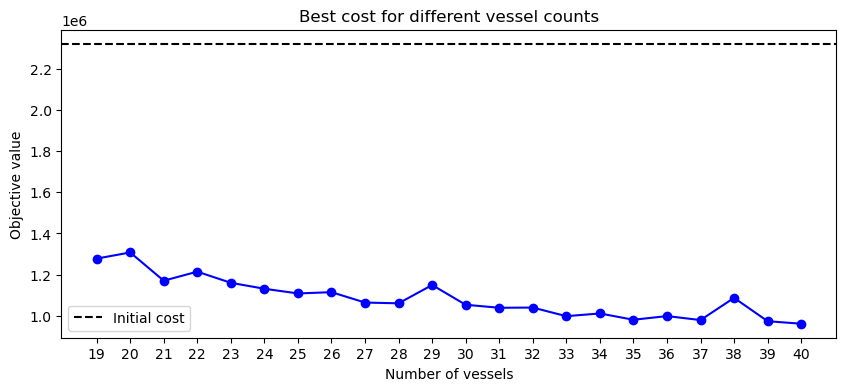

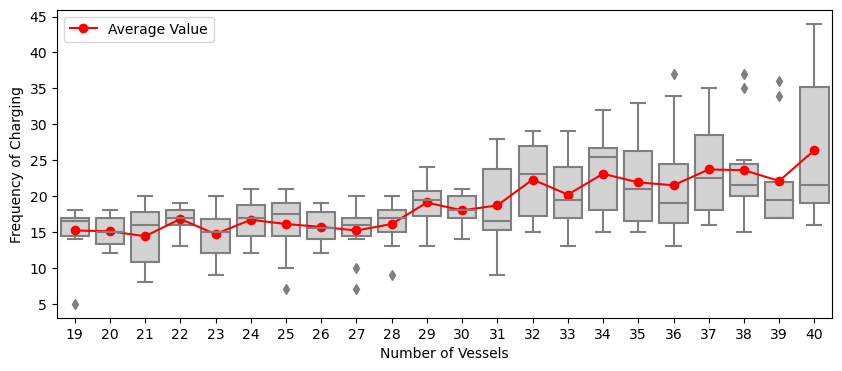

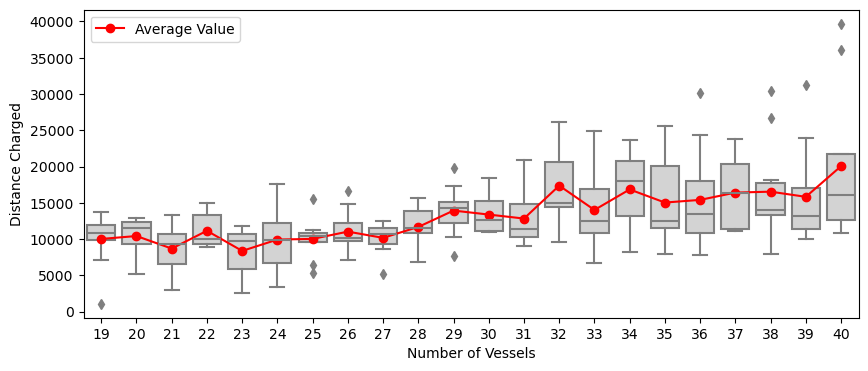

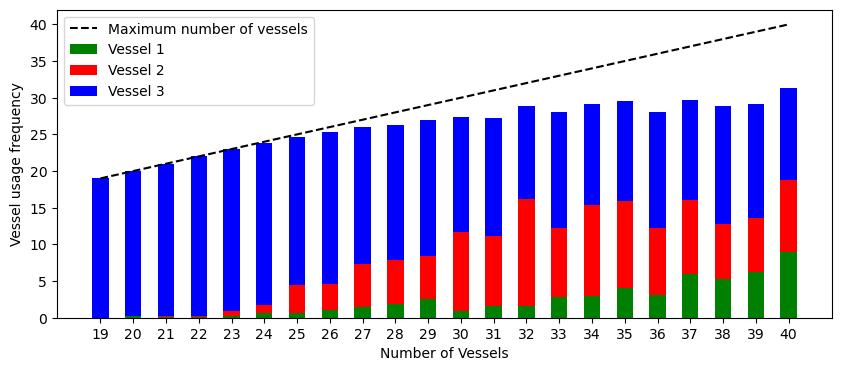

In [157]:
exII_results_plot(exII,save_=True,save_name='/Users/simonhusebo/Dokumenter/MASTERS CODE/figures/ExperimentII/ExperimentII_instance23_1605_2110',initial_cost = initial_cost)